In [1]:
import gym
import os
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed, Memory
from tqdm.notebook import tqdm

memory = Memory("/tmp/tailstorm-avoid-loss_3", verbose=0)

In [2]:
policies = dict(
    tailstorm=[
        "avoid-loss",
        "honest",
        "minor-delay",
        "avoid-loss-a",
        "avoid-loss-b",
        "long-delay",
    ],
)


def points():
    for episode in range(25):
        for alpha in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
            for gamma in [0.05, 0.5, 0.95]:
                for protocol, l in policies.items():
                    for policy in l:
                        yield dict(
                            protocol=protocol,
                            k=8,
                            reward="constant",
                            subblock_selection="heuristic",
                            alpha=alpha,
                            gamma=gamma,
                            policy=policy,
                            episode=episode,
                        )


points = pd.DataFrame(points())
points

,protocol,k,reward,subblock_selection,alpha,gamma,policy,episode
0,tailstorm,8,constant,heuristic,0.1,0.05,avoid-loss,0
1,tailstorm,8,constant,heuristic,0.1,0.05,honest,0
2,tailstorm,8,constant,heuristic,0.1,0.05,minor-delay,0
3,tailstorm,8,constant,heuristic,0.1,0.05,avoid-loss-a,0
4,tailstorm,8,constant,heuristic,0.1,0.05,avoid-loss-b,0
...,...,...,...,...,...,...,...,...
4045,tailstorm,8,constant,heuristic,0.5,0.95,honest,24
4046,tailstorm,8,constant,heuristic,0.5,0.95,minor-delay,24
4047,tailstorm,8,constant,heuristic,0.5,0.95,avoid-loss-a,24
4048,tailstorm,8,constant,heuristic,0.5,0.95,avoid-loss-b,24


In [3]:
protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"

episode_len = 2048


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )


def observe_episode(info):
    r = dict()
    for k, v in info.items():
        if k.startswith("episode_"):
            r[k] = v
    return r


@memory.cache
def measure(env_name, policy, seed=None, **kwargs):
    env = gym.make(env_name, **kwargs)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    res = measure(env_name, x.policy, **kwargs)
    return pd.Series(res)


def parallel_measure(df, fun=measure_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


measurements = parallel_measure(points)

  0%|          | 0/4050 [00:00<?, ?it/s]

In [4]:
df = measurements.assign(
    episode_reward=lambda d: d.episode_reward_attacker / d.episode_progress
)

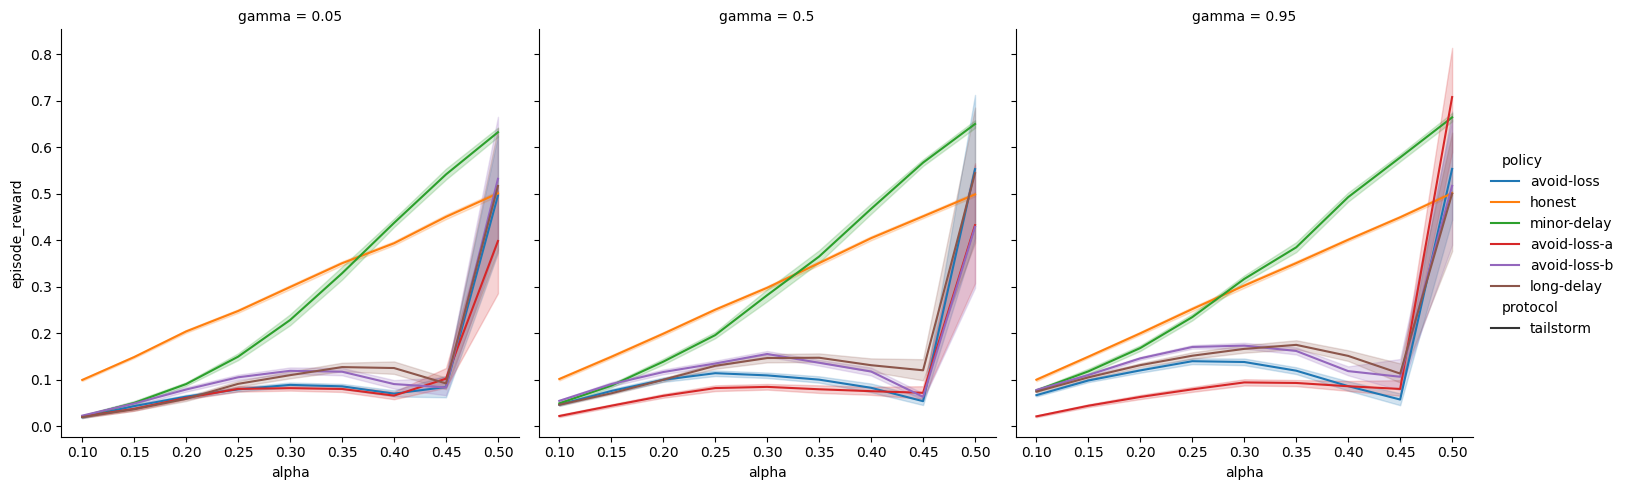

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-144-ge542235-dirty (engine: ~)
cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0

In [5]:
sns.relplot(
    kind="line",
    data=df,
    x="alpha",
    y="episode_reward",
    col="gamma",
    hue="policy",
    style="protocol",
)